# 5.3. Experiments and Evaluation

## Utils

#### Imports

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import numpy as np
from typing import List
import warnings
import sys

# Add the parent directory with local imports
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'lib'))

warnings.filterwarnings(
    "ignore"
)  # Disable long warnings when NaN values are encountered

from utils import load_csv_data


#### Constants declaration

In [41]:
_SCENARIOS = {
    "Landlocked": {
        "type": "Geographical",
        "directions": ["East", "West", "North", "South"]
    },
    "Coastal": {
        "type": "Geographical",
        "directions": ["East", "West", "North", "South"]
    },
    "Insular" : {
        "type": "Geographical",
        "directions": ["East", "West", "North", "South"]
    },
    "Polar": {
        "type": "Latitudinal",
        "directions": ["East", "West", "North", "South"]
    },
    "Equatorial": {
        "type": "Latitudinal",
        "directions": ["East", "West", "North", "South"]
    },
    "TransOrbital": {
        "type": "Orbital",
        "directions": ["East", "West", "North", "South"]
    },
    "IntraOrbital": {
        "type": "Orbital",
        "directions": ["East", "West", "North", "South"]
    },
}


class ScenarioAttribute(dict):
    def __init__(self, attr: str):
        self.attr = attr

    def __getitem__(self, key: str):
        return _SCENARIOS[key][self.attr]


LOG_DIRECTORY = "../../simulator/Logs/"
ALL_DIRECTIONS= ["East", "West", "North", "South"]
DIRECTIONS = ScenarioAttribute("directions")
PALETTES = ScenarioAttribute("palette")
TYPE = ScenarioAttribute("type")
SCENARIOS = list(_SCENARIOS.keys())

IMAX_VALUES = ["OFF", "3", "6", "9"]
REPS = 2 # 100


#### Plotting Classes

In [42]:
from typing import List
import pandas as pd
import seaborn as sns

from utils import load_json_data

from abc import ABC


class Stat(ABC):
    def __init__(self):
        pass

    def plot(self, **kwargs):
        raise NotImplementedError


class MedianLatency(Stat):
    def __init__(self):
        self.data_df = pd.DataFrame()
        pass

    def get_data(self, scenarios: List[str], imax_list: List[int], reps: int):
        # Concatenate data from different iterations into a single DataFrame.
        aggregate_data = []
        for imax in imax_list:
            for scenario in scenarios:
                for direction in ALL_DIRECTIONS: #DIRECTIONS[scenario]:
                    for i in range(0, reps):
                        filename = f"{scenario}_{direction}_{imax}_{i:03d}/rtt.json"
                        data = load_json_data(filename).explode("rtt", ignore_index=True)
                        data["scenario"] = scenario
                        data["direction"] = direction
                        data["imax"] = imax
                        aggregate_data.append(data)
        return pd.concat(aggregate_data, axis=0, ignore_index=True)

class CongestionProbability(Stat):
    def __init__(self):
        pass

    def _get_theoretical_probability(self):
        # THIS IS THE CODE FROM CHAPTER 4
        i_max_arr = [1, 3, 6, 9]
        n = 5
        trials = 5
        theory_dicts = []
        for i_max in i_max_arr:
            theory_dicts.append({
                "direction" : ["Theoretical"],
                "probability" : 1/i_max,        # probability of a successful trial
                "imax" : str(i_max) if i_max != 1 else "OFF"
            })
        return theory_dicts


    def _get_relative_probability(self, scenarios: List[str], imax_list: List[str], reps: int) -> pd.DataFrame:
        probabilities = []
        og_success_indexes = []
        for scenario in scenarios:
            for direction in ALL_DIRECTIONS: #DIRECTIONS[scenario]:
                for imax in imax_list:
                    if imax == "OFF":
                        og_success_indexes = []
                        for i in range(0, reps):
                            filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
                            data = load_csv_data(filename)
                            og_success_indexes.extend(data.index[data["FINAL CAPACITY"] == 0.0].tolist())
                    og_success_indexes = set(og_success_indexes)
                    temp_data = pd.DataFrame(data=
                        {
                            "scenario": [scenario],
                            "direction" : [direction],
                            "probability" : [self._compute_relative_probability(scenario, direction, imax, reps, og_success_indexes) ],
                            "imax" : [imax]
                        }
                    )
                    if imax == "OFF":
                        print(f"{scenario} {direction} OFF: {self._compute_relative_probability(scenario, direction, imax, reps, og_success_indexes)}")
                    probabilities.append(temp_data)

        theory_dicts = self._get_theoretical_probability()
        for scenario in scenarios:
            for theory_dict in theory_dicts:
                theory_dict["scenario"] = [scenario]
                probabilities.append(pd.DataFrame(theory_dict))
        return pd.concat(probabilities, axis=0, ignore_index=True)

    def _compute_relative_probability(self, scenario: str, direction: str, imax: str, reps: int, indexes: set) -> float:
        successes = 0
        attempts = 0
        for i in range(0, reps):
            filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
            data = load_csv_data(filename)
            if imax == "OFF":
                print(len(data))
            data = data[data.index.isin(indexes)]

            # if imax == "OFF":
            #     print(len(data))

            # print(data)
            if 0.0 in data["FINAL CAPACITY"].value_counts():
                successes += data["FINAL CAPACITY"].value_counts()[0.0]
                # if imax == "OFF" and direction == "North" and scenario == "Equatorial":
                    # print(f'SUCCESSES: {data["FINAL CAPACITY"].value_counts()[0.0]}')
            attempts += len(data)

        # if imax == "OFF":
        #     print(indexes)
        #     print(successes)
        #     print(attempts)
        if attempts == 0:
            return np.nan
        # if attempts == 0:
        #     return 0 # TODO: I NEED TO EXCLUDE THIS.
        return successes/attempts

    def _compute_probability(self, scenario: str, direction: str, imax: str, reps: int) -> float:
        successes = 0
        attempts = 0
        for i in range(0, reps):
            filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
            data = load_csv_data(filename)
            if 0.0 in data["FINAL CAPACITY"].value_counts():
                successes += data["FINAL CAPACITY"].value_counts()[0.0]
            attempts += len(data)
            # NOTE: SHOULD I AVERAGE IT OUT INSTEAD? I WONDER...
        return successes/attempts


    def _get_data(self, scenarios: List[str], imax_list: List[str], reps: int) -> pd.DataFrame:
        probabilities = []
    
        for imax in imax_list:
            for scenario in scenarios:
                for direction in ALL_DIRECTIONS: #DIRECTIONS[scenario]:
                    temp_data = pd.DataFrame(data=
                        {
                            "scenario": [scenario],
                            "direction" : [direction],
                            "probability" : [self._compute_probability(scenario, direction, imax, reps) ],
                            "imax" : [imax]
                        }
                        )
                    probabilities.append(temp_data)

        return pd.concat(probabilities, axis=0, ignore_index=True)


from scipy.stats import binom

class ExpectedMaliciousTraffic(Stat):

    def _get_theoretical_traffic(self):
        i_max_arr = [1, 3, 6, 9]       # Number of different possible values of r_max.
        trials = 5

        theory_dicts = []
        for i_max in i_max_arr:
            p = 1/i_max
            data = binom.rvs(trials, p, size=100*30) * 4000
            for data_pt in data:
                theory_dicts.append({
                    "direction" : "Theory",
                    "FINAL CAPACITY" : data_pt, #binom.mean(trials, p)*4000,
                    "imax" : str(i_max) if i_max != 1 else "OFF"
                })

        return theory_dicts

    def _get_relative_traffic(self, scenarios: List[str], imax_list: List[str], reps: int) -> pd.DataFrame:
        probabilities = []
        og_success_indexes = []
        for scenario in scenarios:
            for direction in ALL_DIRECTIONS: #DIRECTIONS[scenario]:
                og_success_indexes = []
                group = []
                for imax in imax_list:
                    if imax == "OFF":
                        # og_success_indexes = []
                        for i in range(0, reps):
                            filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
                            data = load_csv_data(filename)
                            data["scenario"] = scenario
                            data["direction"] = direction
                            data["imax"] = imax
                            data["FINAL CAPACITY"] = 20000 - data["FINAL CAPACITY"]
                            # og_success_indexes.extend(data.index[data["FINAL CAPACITY"] == 0.0].tolist())
                            # data = data[data.index.isin(og_success_indexes)]
                            group.append(data)

                        # og_success_indexes = set(og_success_indexes)
                    else:
                        for i in range(0, reps):  # ran 100 instances.
                            filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
                            data = load_csv_data(filename) #.explode("FINAL CAPACITY", ignore_index=True)
                            data["FINAL CAPACITY"] = 20000 - data["FINAL CAPACITY"]
                            # data = data[data.index.isin(og_success_indexes)]
                            data["scenario"] = scenario
                            data["direction"] = direction
                            data["imax"] = imax
                            group.append(data)
                # TODO: SCALE THE DATA.
                group = pd.concat(group, axis=0, ignore_index=True)
                # group["FINAL CAPACITY"] = group["FINAL CAPACITY"] / group["FINAL CAPACITY"].max()
                probabilities.append(group)
                    # probabilities.append(data)

        theory_dicts = self._get_theoretical_traffic()
        # TODO: PUT THE BELOW LATER ON
        for scenario in scenarios:
            for theory_dict in theory_dicts:
                theory_dict["scenario"] = [scenario]
                probabilities.append(pd.DataFrame(theory_dict))
        final_df = pd.concat(probabilities, axis=0, ignore_index=True)
        # NORMALIZE THE DATA
        for scenario in scenarios:
            for direction in ALL_DIRECTIONS: #DIRECTIONS[scenario]:
                group = final_df[(final_df["scenario"] == scenario) & (final_df["direction"] == direction)]
                group["FINAL CAPACITY"] = group["FINAL CAPACITY"] / group["FINAL CAPACITY"].max()
                final_df.loc[(final_df["scenario"] == scenario) & (final_df["direction"] == direction), "FINAL CAPACITY"] = group["FINAL CAPACITY"]


        return final_df
        # return pd.concat(probabilities, axis=0, ignore_index=True)

    def _get_data(
        self, scenarios: List[str], imax_list: List[str], reps: int
    ) -> pd.DataFrame:
        aggregate_data = []

        for imax in imax_list:
            for scenario in scenarios:
                for direction in ALL_DIRECTIONS:
                    # Concatenate data from different iterations into a single DataFrame.
                    for i in range(0, reps):  # ran 100 instances.
                        filename = f"{scenario}_{direction}_{imax}_{i:03d}/attack.csv"
                        # TODO: do something if the file doesn't exist.
                        data = load_csv_data(filename) #.explode("FINAL CAPACITY", ignore_index=True)
                        data["FINAL CAPACITY"] = 20000 - data["FINAL CAPACITY"]
                        data["scenario"] = scenario
                        data["direction"] = direction
                        data["imax"] = imax
                        aggregate_data.append(data)
                    
                    # new = pd.concat(agg_data, axis=0, ignore_index=True)
                    # aggregate_data.append(new)

        data_ds = pd.concat(aggregate_data, axis=0, ignore_index=True)
        # data_ds["FINAL CAPACITY"] = data["FINAL CAPACITY"] / 1000
        return data_ds

### Load data

In [43]:
latency_df = MedianLatency().get_data(SCENARIOS, IMAX_VALUES, REPS)
baseline_latency_df = latency_df[latency_df['imax'] == 'OFF']

congestion_df = CongestionProbability()._get_data(SCENARIOS, IMAX_VALUES, REPS)
baseline_congestion_df = congestion_df[congestion_df['imax'] == 'OFF']

traffic_df = ExpectedMaliciousTraffic()._get_data(SCENARIOS, IMAX_VALUES, REPS)
baseline_traffic_df = traffic_df[traffic_df['imax'] == 'OFF']

relative_congestion_df = CongestionProbability()._get_relative_probability(SCENARIOS, IMAX_VALUES, REPS)
baseline_relative_congestion_df = congestion_df[congestion_df['imax'] == 'OFF']
relative_traffic_df = ExpectedMaliciousTraffic()._get_relative_traffic(SCENARIOS, IMAX_VALUES, REPS)


31
31
31
31
Landlocked East OFF: 0.9047619047619048
31
31
31
31
Landlocked West OFF: 1.0
31
31
31
31
Landlocked North OFF: 1.0
31
31
31
31
Landlocked South OFF: 1.0
31
31
31
31
Coastal East OFF: nan
31
31
31
31
Coastal West OFF: 1.0
31
31
31
31
Coastal North OFF: nan
31
31
31
31
Coastal South OFF: 1.0
31
31
31
31
Insular East OFF: nan
31
31
31
31
Insular West OFF: nan
31
31
31
31
Insular North OFF: nan
31
31
31
31
Insular South OFF: nan
31
31
31
31
Polar East OFF: nan
31
31
31
31
Polar West OFF: nan
31
31
31
31
Polar North OFF: nan
31
31
31
31
Polar South OFF: nan
31
31
31
31
Equatorial East OFF: 0.7
31
31
31
31
Equatorial West OFF: nan
31
31
31
31
Equatorial North OFF: 1.0
31
31
31
31
Equatorial South OFF: nan
31
31
31
31
TransOrbital East OFF: nan
31
31
31
31
TransOrbital West OFF: nan
31
31
31
31
TransOrbital North OFF: nan
31
31
31
31
TransOrbital South OFF: nan
31
31
31
31
IntraOrbital East OFF: 0.925
31
31
31
31
IntraOrbital West OFF: 1.0
31
31
31
31
IntraOrbital North OFF: 1.0
3

### Plot settings

In [44]:
sns.set(font_scale=0.8) 
sns.set_style("darkgrid")


rids_congestion_df = congestion_df[congestion_df["scenario"] != "Insular"]
rids_congestion_df = rids_congestion_df[rids_congestion_df["scenario"] != "TransOrbital"]
                                  
rids_latency_df = latency_df[latency_df["scenario"] != "Insular"]
rids_latency_df = rids_latency_df[rids_latency_df["scenario"] != "TransOrbital"]

rids_traffic_df = traffic_df[traffic_df["scenario"] != "Insular"]
rids_traffic_df = rids_traffic_df[traffic_df["scenario"] != "TransOrbital"]

----
## Baseline performance

### Probability of Congestion by Scenario and Direction: Baseline

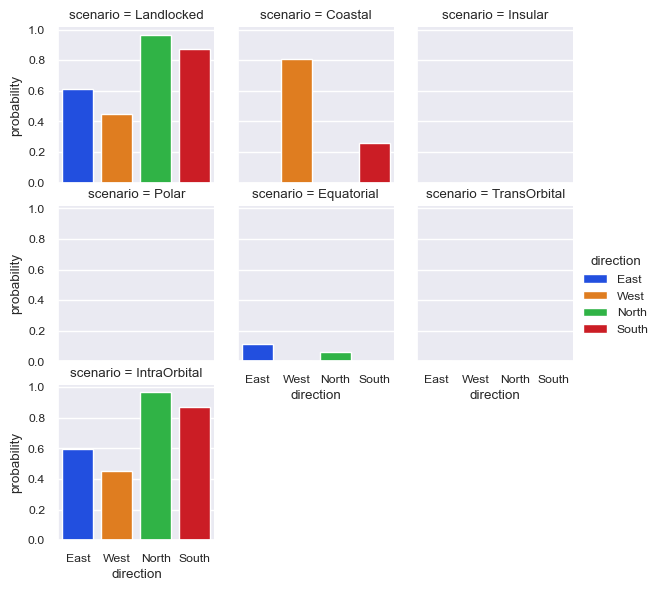

In [45]:

sns.set_palette(sns.color_palette('bright'))
g = sns.FacetGrid(baseline_congestion_df, col="scenario", hue="direction", col_wrap=3, margin_titles=True, height=2) #, height=2) #, aspect=1.5)
g.map_dataframe(sns.barplot,  x='direction', y='probability')
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
plt.savefig("../images/baseline_probability.svg")

### Expected Malicious Traffic by Scenario and Direction: Baseline

[-10000.      0.  10000.  20000.  30000.]
[-10000.      0.  10000.  20000.  30000.]
[-10000.      0.  10000.  20000.  30000.]
[-10000.      0.  10000.  20000.  30000.]
[-10000.      0.  10000.  20000.  30000.]
[-10000.      0.  10000.  20000.  30000.]
[-10000.      0.  10000.  20000.  30000.]


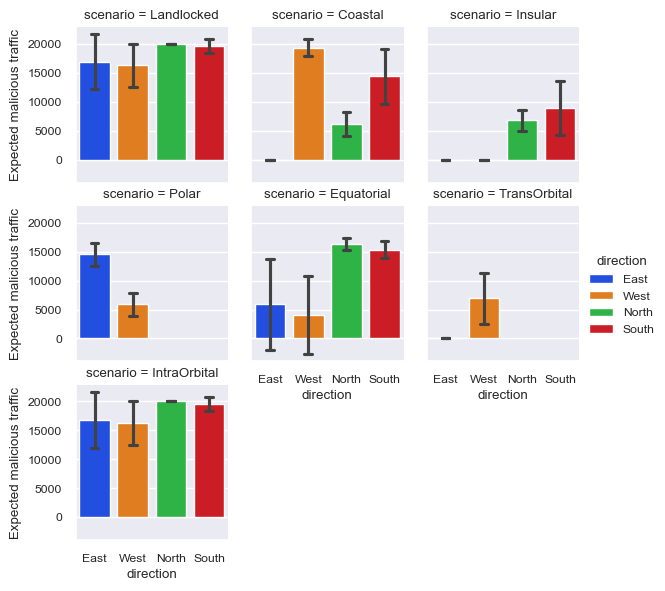

In [46]:
sns.set_palette(sns.color_palette('bright'))
g = sns.FacetGrid(baseline_traffic_df, col="scenario", col_wrap=3, hue="direction", margin_titles=True, height=2)
g.map_dataframe(sns.barplot,
        x="direction",
        y="FINAL CAPACITY",
        ci="sd",
        capsize=0.2,
        estimator=np.mean,
    )
g.set_ylabels("Expected malicious traffic")

# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))
for ax in g.axes: #.flat:
    print(ax.get_yticks())
#     ylabels = ['{}'.format(x) for x in ax.get_yticks()/1000]
#     print(ylabels)
#     ax.set_yticklabels(ylabels)
# ylabels = ['{:,.2f}'.format(x) + 'K' for x in g.get_yticks()/1000]
# g.set_yticklabels(ylabels)
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
plt.savefig("../images/baseline_traffic.svg")

### Network Latency by Scenario and Direction: Baseline

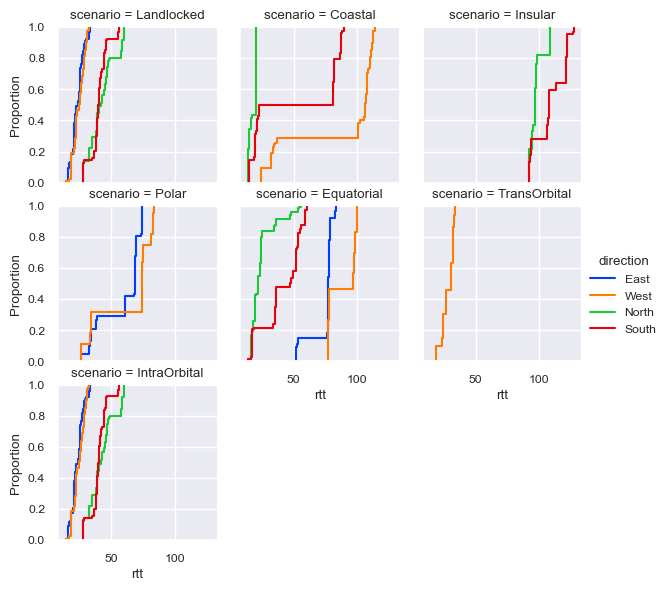

In [47]:
sns.set_palette(sns.color_palette('bright'))
g = sns.FacetGrid(baseline_latency_df, col="scenario", hue="direction", col_wrap=3, margin_titles=True, height=2)
g.map_dataframe(sns.ecdfplot,
        x="rtt",
    )
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
plt.savefig("../images/baseline_rtt_cdf.svg")


### Network Latency Timeseries

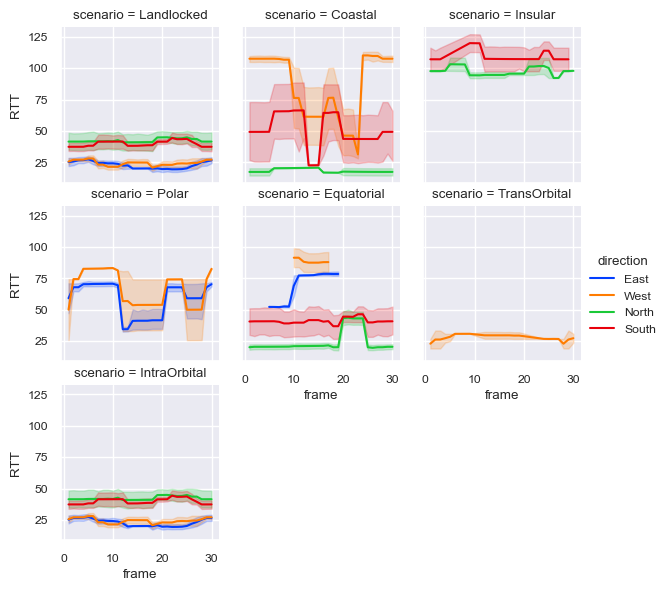

In [48]:

sns.set_palette(sns.color_palette('bright'))
g = sns.FacetGrid(baseline_latency_df, col="scenario", hue="direction", col_wrap=3, margin_titles=True, height=2)
g.map_dataframe(sns.lineplot,
        x='frame',
        y="rtt",
    )
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
g.set_ylabels("RTT")
plt.savefig("../images/baseline_rtt_timeseries.svg")

---

## RiDS Performance

#### Congestion Probability by Scenario and Direction: RiDS Enabled

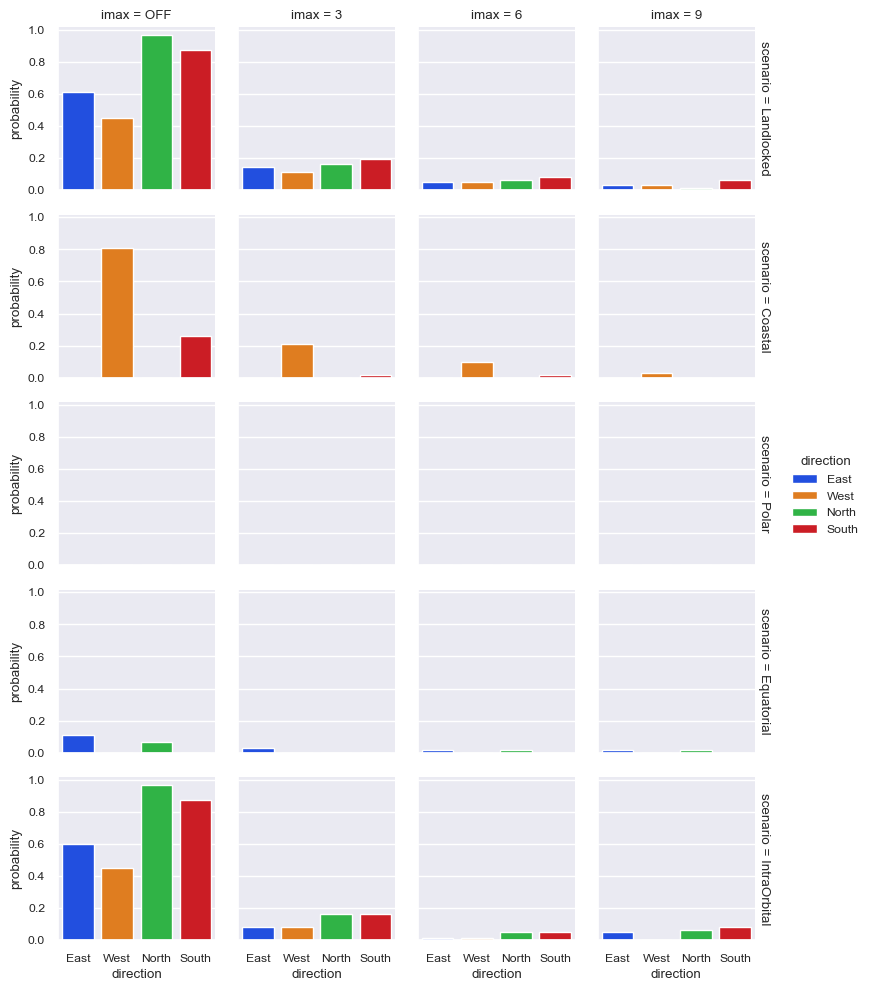

In [49]:
g = sns.FacetGrid(rids_congestion_df, row="scenario", col="imax", hue="direction", margin_titles=True, height=2)
g.map_dataframe(sns.barplot,  x='direction', y='probability')
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
plt.savefig("../images/rids_probability.svg")
plt.show()

### Expected Malicious Traffic by Scenario and Direction: RiDS enabled

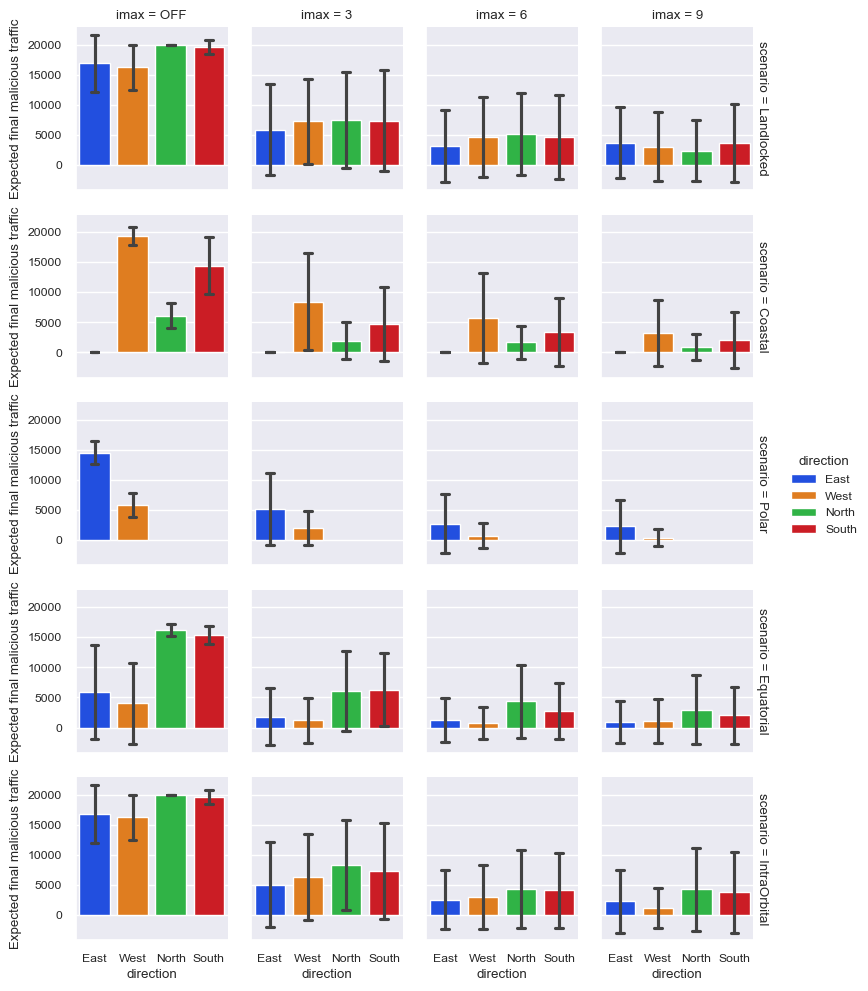

In [50]:
sns.set_palette(sns.color_palette('bright'))

g = sns.FacetGrid(rids_traffic_df, col="imax", hue="direction", row='scenario', margin_titles=True, height=2)
# g = sns.FacetGrid(traffic_df, col="imax", hue="scenario", row='direction', margin_titles=True, height=2)
g.map_dataframe(sns.barplot,
        x="direction",
        y="FINAL CAPACITY",
        ci="sd",
        capsize=0.2,
        estimator=np.mean,
    )

# TODO: CONVERT THESE VALUES TO GBPS
g.set_ylabels("Expected final malicious traffic")
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
plt.savefig("../images/rids_expected.svg")

#### Network Latency by Scenario and Direction: RiDS enabled

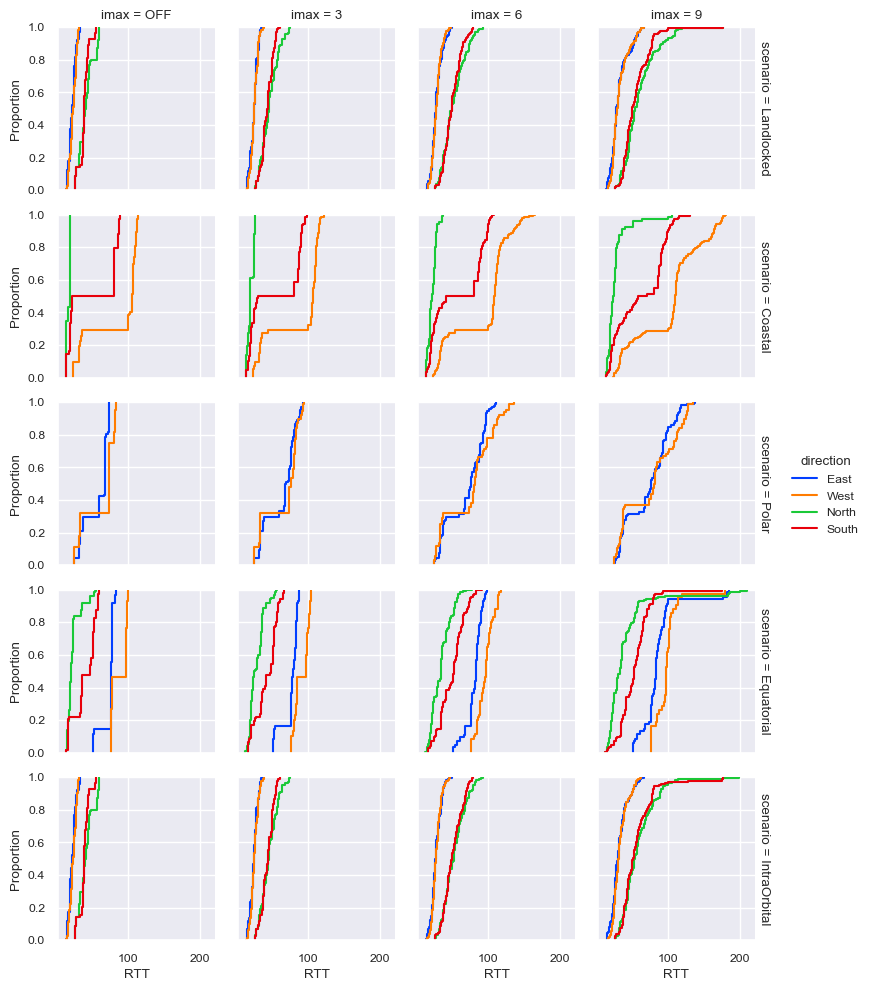

In [51]:
g = sns.FacetGrid(rids_latency_df, col="imax", row="scenario", hue="direction", margin_titles=True, height=2)
g.map_dataframe(sns.ecdfplot,
                x="rtt",
            )
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
g.set_xlabels("RTT")
plt.savefig("../images/rids_rtt_cdf.svg")

### Network Latency Timeseries: RiDS Enabled

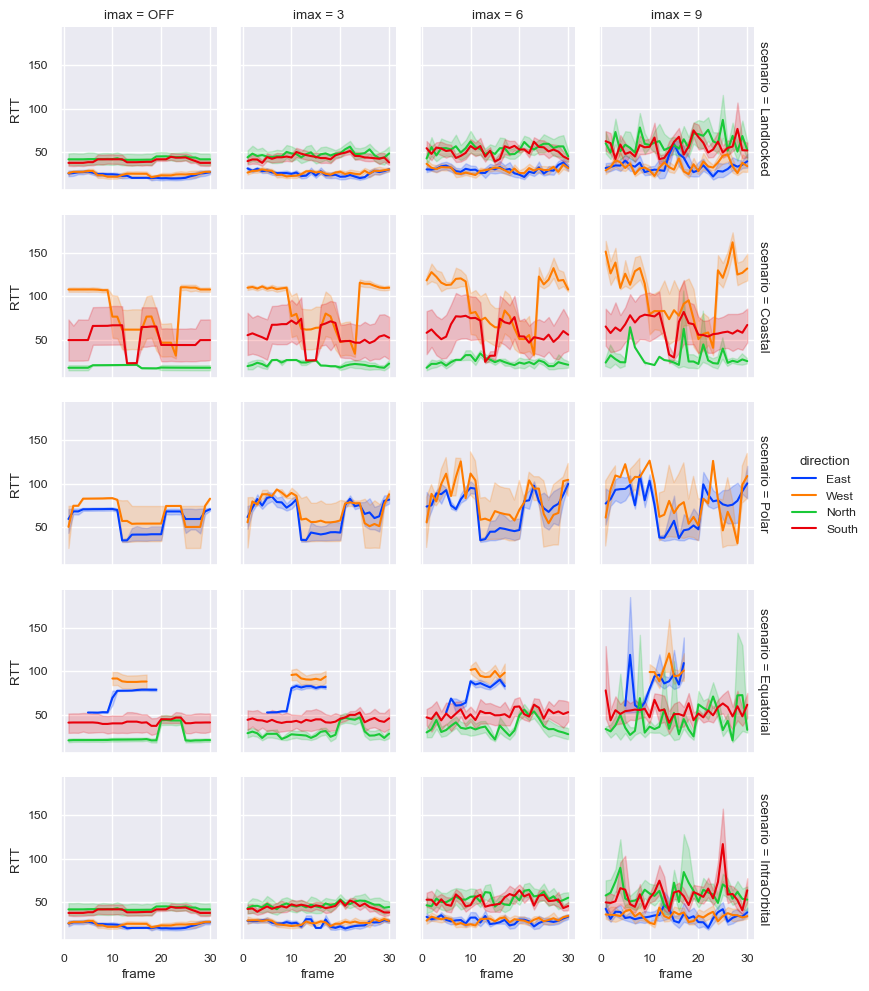

In [52]:
g = sns.FacetGrid(rids_latency_df, col="imax", row="scenario", hue="direction", margin_titles=True, height=2)
g.map_dataframe(sns.lineplot, x="frame", y="rtt")
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
g.set_ylabels("RTT")
plt.savefig("../images/rids_rtt_timeseries.svg")

## Theory vs. Application (DO THIS LATER)

#### Probability of Congestion

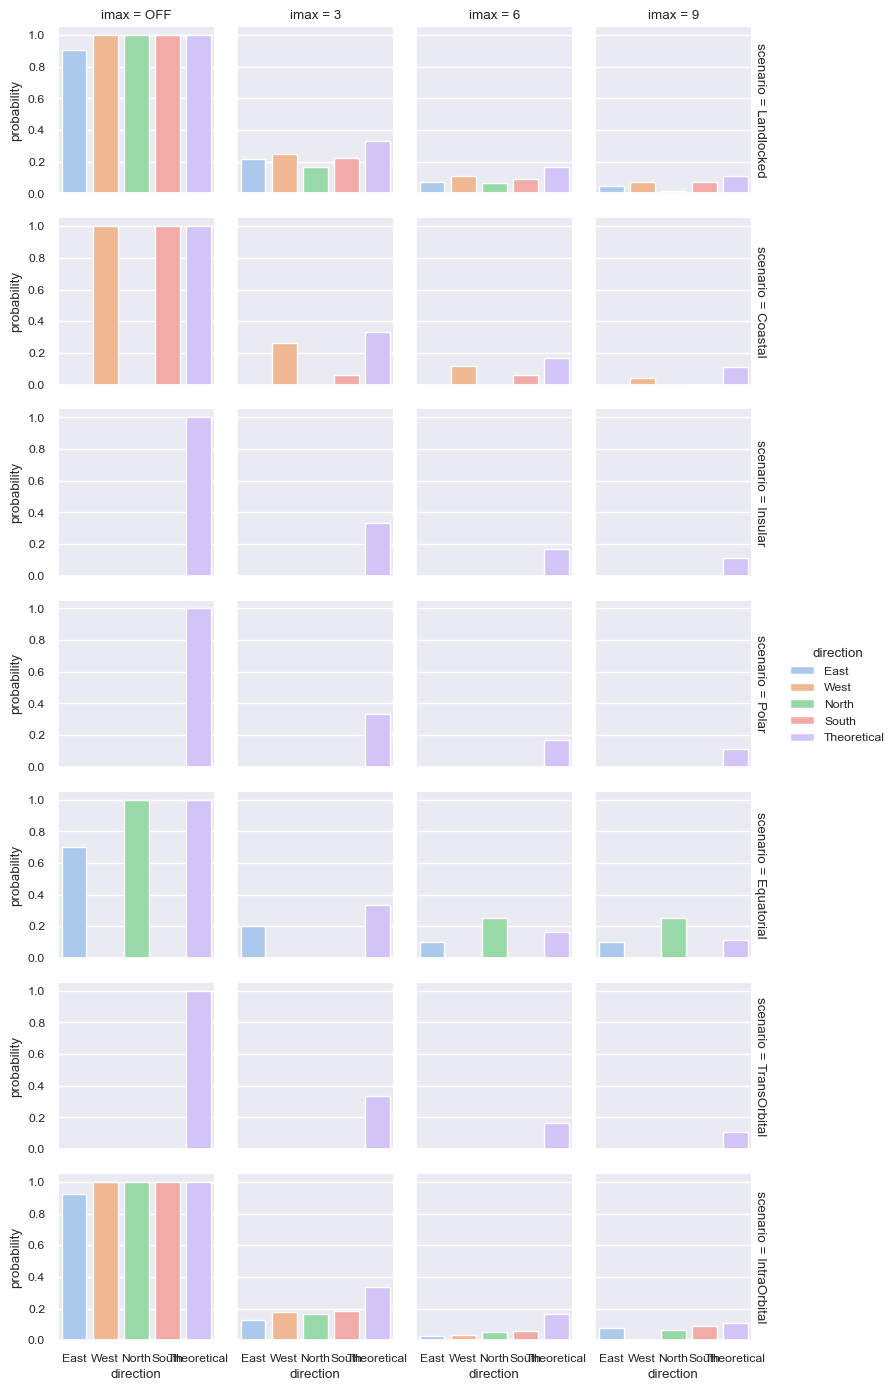

In [53]:
# RELATIVE PROBABILITY.

# TODO I NEED TO ACTUALLY GRAB THE THEORETICAL VALUES TO COMPARE HAHA

sns.set_palette(sns.color_palette('pastel'))

g = sns.FacetGrid(relative_congestion_df, row="scenario", col="imax", hue="direction", margin_titles=True, height=2)
g.map_dataframe(sns.barplot,  x='direction', y='probability')
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
plt.show()

### Expected Malicious Traffic: Normalized

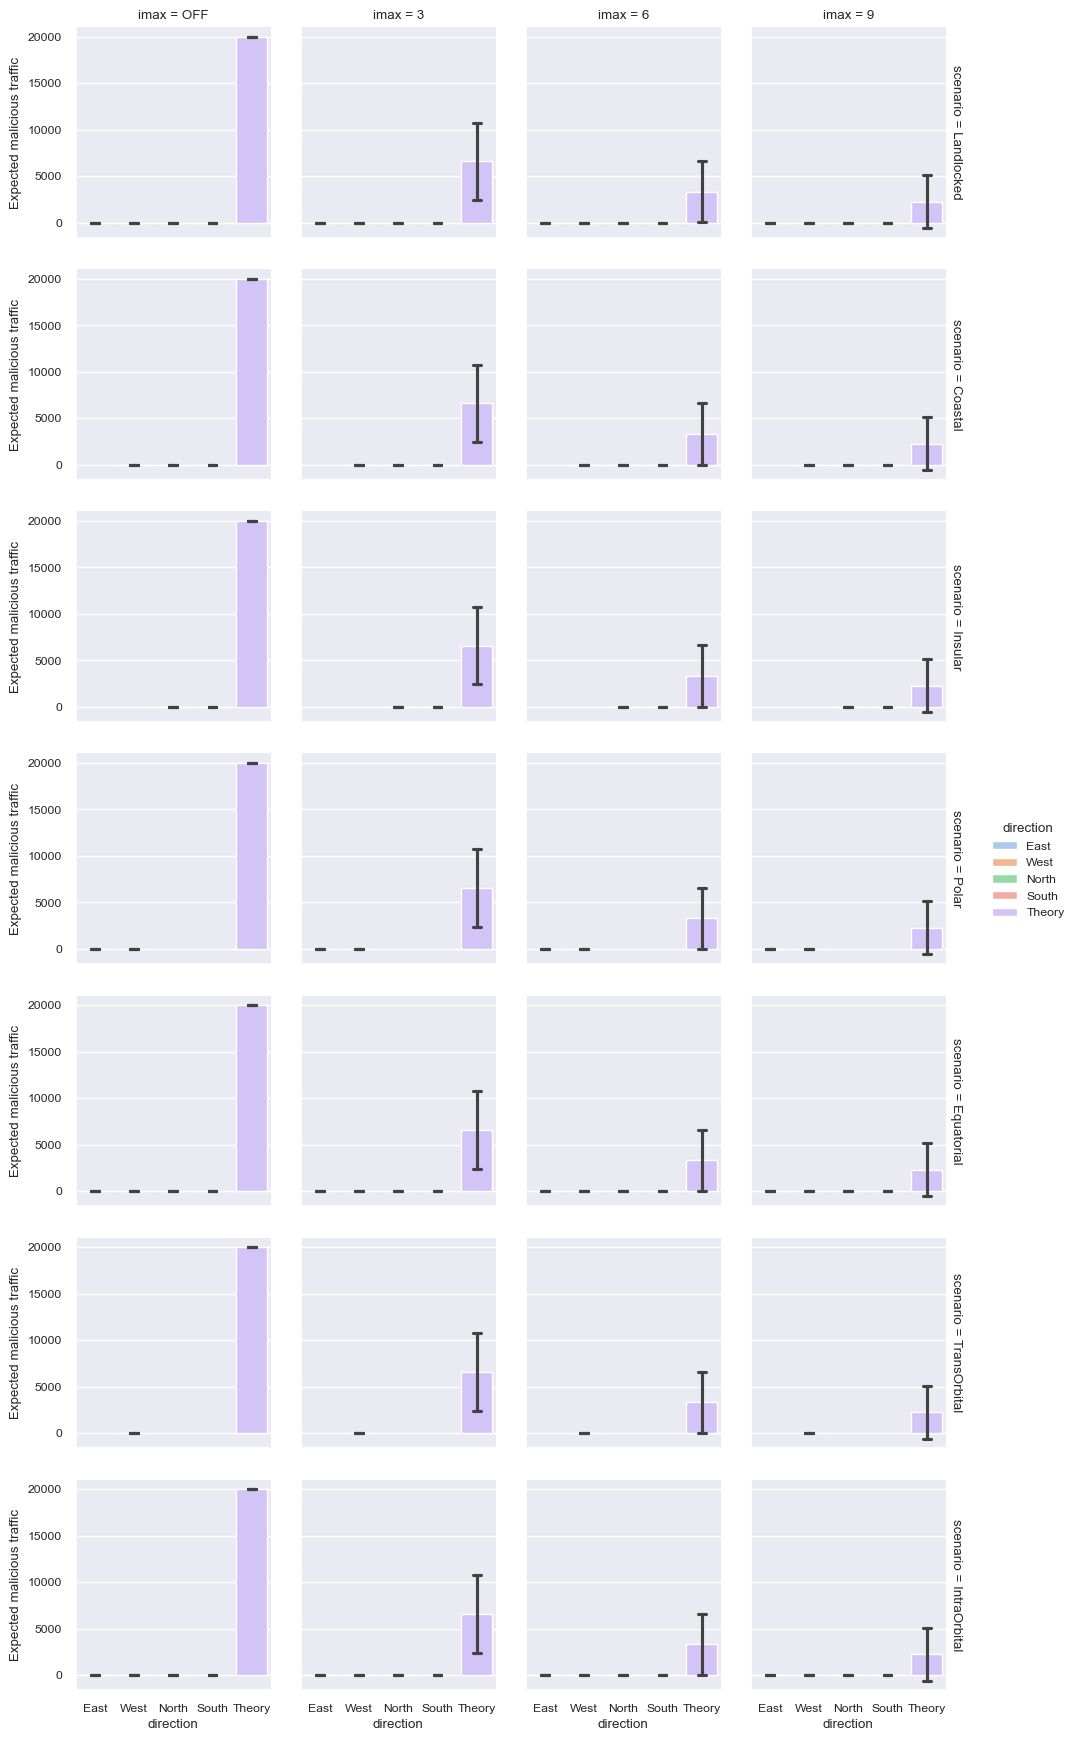

In [54]:
sns.set_palette(sns.color_palette('pastel'))

# INSTEAD WE ARE GOING TO NORMALISE THIS.


# scaled_traffic_df = relative_traffic_df.copy()
# scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & (scaled_traffic_df["scenario"] == "Equatorial")]["FINAL CAPACITY"] = scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & ( scaled_traffic_df["scenario"] == "Equatorial")]["FINAL CAPACITY"] / scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & (scaled_traffic_df["scenario"] == "Equatorial")]["FINAL CAPACITY"].max()


# display(scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & ( scaled_traffic_df["scenario"] == "Equatorial")]["FINAL CAPACITY"] / scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & (scaled_traffic_df["scenario"] == "Equatorial")]["FINAL CAPACITY"].max())
# display(scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & (scaled_traffic_df["scenario"] == "Equatorial")]["FINAL CAPACITY"].max())
# # relative_traffic_df_scaled["FINAL CAPACITY"] = 
# scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & (scaled_traffic_df["scenario"] == "Polar")]["FINAL CAPACITY"] = scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & (scaled_traffic_df["scenario"] == "Polar")]["FINAL CAPACITY"] / scaled_traffic_df[(scaled_traffic_df["direction"] == "North") & (scaled_traffic_df["scenario"] == "Polar")]["FINAL CAPACITY"].max()
# relative_traffic_df_scaled[relative_traffic_df_scaled["direction"] == "North"]["FINAL CAPACITY"] / relative_traffic_df_scaled[relative_traffic_df_scaled["direction"] == "North"]["FINAL CAPACITY"].max()
# display(len(relative_traffic_df[relative_traffic_df["direction"] == "North"]))

# display(relative_traffic_df[(scaled_traffic_df["direction"] == "North") & (scaled_traffic_df["scenario"] == "Equatorial")])
g = sns.FacetGrid(relative_traffic_df, col="imax", hue="direction", row='scenario', margin_titles=True, height=2.5)
g.map_dataframe(sns.barplot,
        x="direction",
        y="FINAL CAPACITY",
        ci="sd",
        capsize=0.2,
        estimator=np.mean,
    )
g.set_ylabels("Expected malicious traffic")
g.figure.subplots_adjust(wspace=.15, hspace=.15)    
g.add_legend()
plt.show()